In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
from scipy import interpolate
from scipy.signal import savgol_filter

from sys import stdout

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

In [3]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (data_msc, ref)

In [4]:
def base_pls(X,y,n_components, return_model=False):

    # Simple PLS
    pls_simple = PLSRegression(n_components=n_components)
    # Fit
    pls_simple.fit(X, y)
    # Cross-validation
    y_cv = cross_val_predict(pls_simple, X, y, cv=10)

    # Calculate scores
    score = r2_score(y, y_cv)
    rmsecv = np.sqrt(mean_squared_error(y, y_cv))

    if return_model == False:
        return(y_cv, score, rmsecv)
    else:
        return(y_cv, score, rmsecv, pls_simple)

In [5]:
def pls_optimise_components(X, y, npc):

    rmsecv = np.zeros(npc)
    for i in range(1,npc+1,1):

        # Simple PLS
        pls_simple = PLSRegression(n_components=i)
        # Fit
        pls_simple.fit(X, y)
        # Cross-validation
        y_cv = cross_val_predict(pls_simple, X, y, cv=10)

        # Calculate scores
        score = r2_score(y, y_cv)
        rmsecv[i-1] = np.sqrt(mean_squared_error(y, y_cv))

    # Find the minimum of ther RMSE and its location
    opt_comp, rmsecv_min = np.argmin(rmsecv),  rmsecv[np.argmin(rmsecv)]

    return (opt_comp+1, rmsecv_min)

In [6]:
def regression_plot(y_ref, y_pred, title = None, variable = None):

    # Regression plot
    z = np.polyfit(y_ref, y_pred, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_ref, y_pred, c='red', edgecolors='k')
        ax.plot(y_ref, z[1]+z[0]*y_ref, c='blue', linewidth=1)
        ax.plot(y_ref, y_ref, color='green', linewidth=1)

        if title is not None:
            plt.title(title)
        if variable is not None:
            plt.xlabel('Measured ' + variable)
            plt.ylabel('Predicted ' + variable)

        plt.show()

In [14]:
def band_selection_sa(X,y,n_of_bands, max_lv, n_iter):

    p = np.arange(X.shape[1])
    np.random.shuffle(p)
    bands = p[:n_of_bands] # Selected Bands. Start off with a random selection
    nbands = p[n_of_bands:] # Excluded bands

    Xop = X[:,bands] #This is the array to be optimised

    # Run a PLS optimising the number of latent variables
    opt_comp, rmsecv_min = pls_optimise_components(Xop, y, max_lv)

    rms = [] # Here we store the RMSE value as the optimisation progresses     
    for i in range(n_iter):

        cool = 0.001*rmsecv_min # cooling parameter. It decreases with the RMSE
        new_bands = np.copy(bands)
        new_nbands = np.copy(nbands)

        # swap three elements at random
        for jj in range(3):
            r1, r2 = np.random.randint(n_of_bands),np.random.randint(X.shape[1]-n_of_bands)
            el1, el2 = new_bands[r1],new_nbands[r2]
            new_bands[r1] = el2
            new_nbands[r2] = el1


        Xop = X[:,new_bands]

        opt_comp_new, rmsecv_min_new = pls_optimise_components(Xop, y, max_lv)

        # If the new RMSE is less than the previous, accept the change
        if (rmsecv_min_new < rmsecv_min):
            bands = new_bands
            nbands = new_nbands
            opt_comp = opt_comp_new
            rmsecv_min = rmsecv_min_new
            rms.append(rmsecv_min_new)
        
            stdout.write("\r"+str(i))
            stdout.write(" ")
            stdout.write(str(opt_comp_new))
            stdout.write(" ")
            stdout.write(str(rmsecv_min_new))
            stdout.flush()

        # If the new RMSE is larger than the previous, accept it with some probability
        # dictated by the cooling parameter
        if (rmsecv_min_new > rmsecv_min):
            
            prob = np.exp(-(rmsecv_min_new - rmsecv_min)/cool) # probability
            if (np.random.random() < prob):
                bands = new_bands
                nbands = new_nbands
                opt_comp = opt_comp_new
                rmsecv_min = rmsecv_min_new
                rms.append(rmsecv_min_new)
                
                stdout.write("\r"+str(i))
                stdout.write(" ")
                stdout.write(str(opt_comp_new))
                stdout.write(" ")
                stdout.write(str(rmsecv_min_new))
                stdout.flush()
            else:
                rms.append(rmsecv_min)
    
    stdout.write("\n")
    print(np.sort(bands))
    print('end')

    return(bands, opt_comp,rms)    

In [7]:
# Load data from Nirpy Reserach Github data page
url = "https://raw.githubusercontent.com/nevernervous78/nirpyresearch/master/data/NIRplums_brix_firmness.csv"
data = pd.read_csv(url)
wl = np.linspace(1102, 2300, 600)

In [8]:
# Extract the arrays
X = -np.log(data.values[:,3:])
brix = data["Brix"]

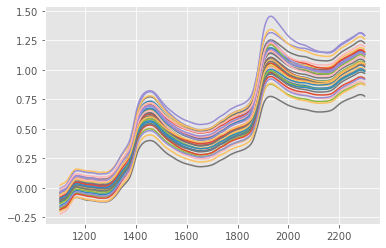

In [9]:
with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.show()

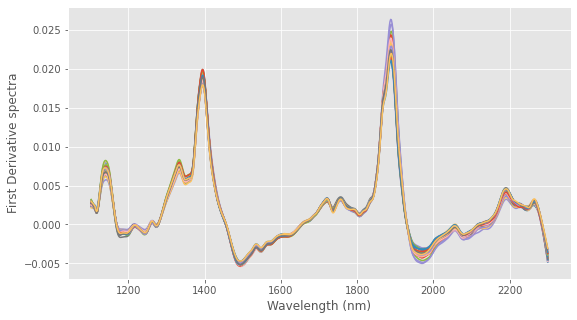

In [10]:
# Multiplicative Scatter Correction
Xc, ref = msc(X)
# First Derivative Smoothing
Xc = savgol_filter(Xc,11,3, deriv=1)
# Plot Data
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(wl, Xc.T)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("First Derivative spectra")
plt.show()    

In [11]:
# Resample spectra. Here is 60 bands
XX = Xc.reshape(Xc.shape[0],60,10).sum(axis=2)

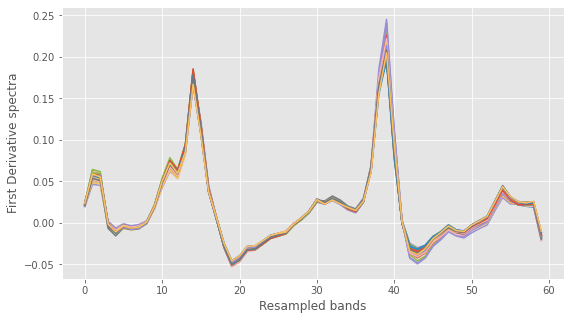

In [12]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(XX.T)
    ax.set_xlabel("Resampled bands")
    ax.set_ylabel("First Derivative spectra")
plt.show() 

PLS results:
   R2: 0.718, RMSE: 0.501
   Number of Latent Variables: 7


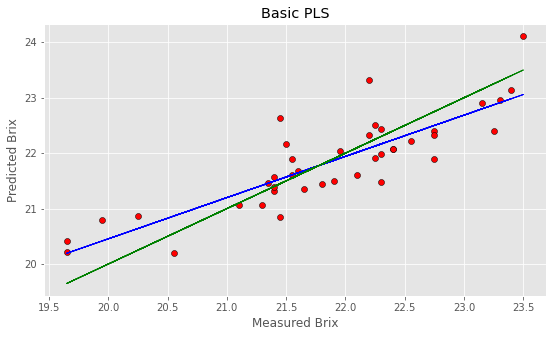

In [13]:
opt_comp, rmsecv_min = pls_optimise_components(Xc, brix, 20)
predicted, r2cv, rmscv = base_pls(Xc, brix, opt_comp)
print("PLS results:")
print("   R2: %5.3f, RMSE: %5.3f"%(r2cv, rmscv))
print("   Number of Latent Variables: "+str(opt_comp))

regression_plot(brix, predicted, title="Basic PLS", variable = "Brix")

975 18 0.21090051032270832
[ 0  1  2  8 18 22 25 26 27 28 30 31 32 34 36 38 39 41 45 58]
end
PLS optimised bands:
   R2: 0.950, RMSE: 0.211
   Number of Latent Variables: 18


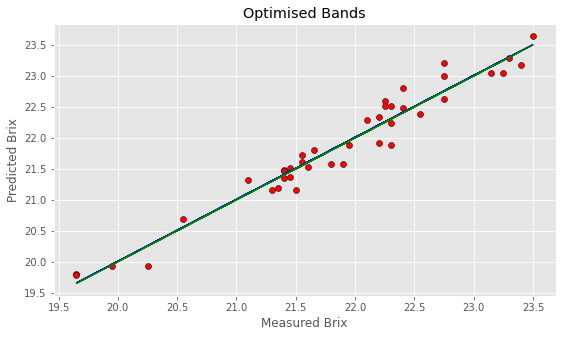

In [15]:
bands, opt_comp, rms = band_selection_sa(XX,brix,n_of_bands = 20, max_lv = 20, n_iter = 1000)
predicted, r2cv, rmscv = base_pls(XX[:,bands], brix, opt_comp)

print("PLS optimised bands:")
print("   R2: %5.3f, RMSE: %5.3f"%(r2cv, rmscv))
print("   Number of Latent Variables: "+str(opt_comp))

regression_plot(brix, predicted, title="Optimised Bands", variable = "Brix")

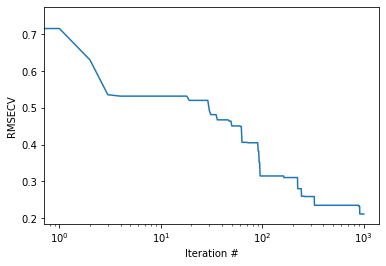

In [18]:
plt.semilogx(rms)
plt.xlabel("Iteration #")
plt.ylabel("RMSECV")
plt.show()

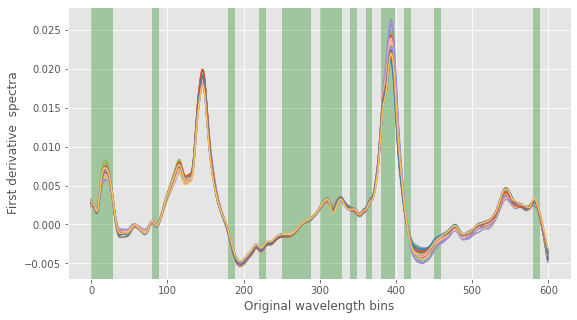

In [17]:
# ix is the index of the selected bands
ix = np.in1d(np.arange(60).ravel(), np.sort(bands))
# To overlap the bands on the original spectrum, we restore the original band size 
ixx = np.repeat(ix,10)

# Plot spectra with superimposed selected bands
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(np.arange(Xc.shape[1]),Xc.T)
    plt.ylabel('First derivative  spectra')
    plt.xlabel('Original wavelength bins')
    collection = collections.BrokenBarHCollection.span_where(
        np.arange(Xc.shape[1]), ymin=-1, ymax=1, where=(ixx == True), facecolor='green', alpha=0.3)
    ax.add_collection(collection)
plt.show()